In [59]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
import pandas_datareader as pdr
from datetime import datetime


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


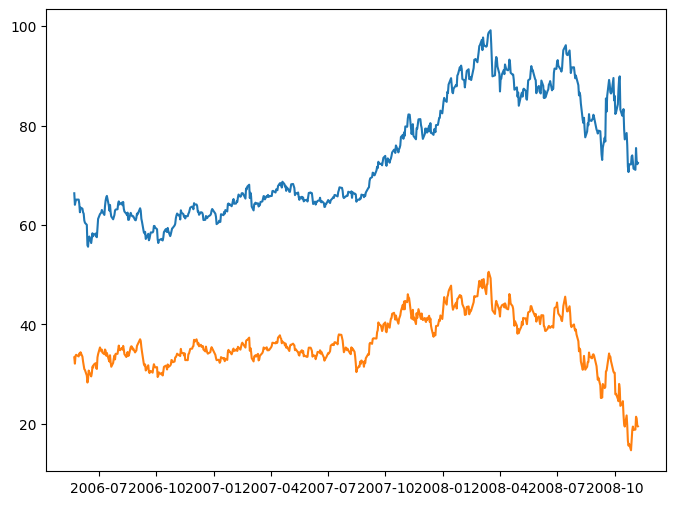

In [60]:
df1 = yf.download('GLD' , datetime(2006,5, 23), datetime(2008, 11, 9))['Adj Close']
df2 = yf.download('GDX', datetime(2006,5, 23), datetime(2008, 11, 9))['Adj Close']
df = pd.merge(df1, df2, on='Date', suffixes=('_GLD', '_GDX'))

train = np.arange(0, 252)
test = np.arange(train.shape[0], df.shape[0])

plt.rcParams['figure.figsize'] = 8, 6
plt.plot(df)


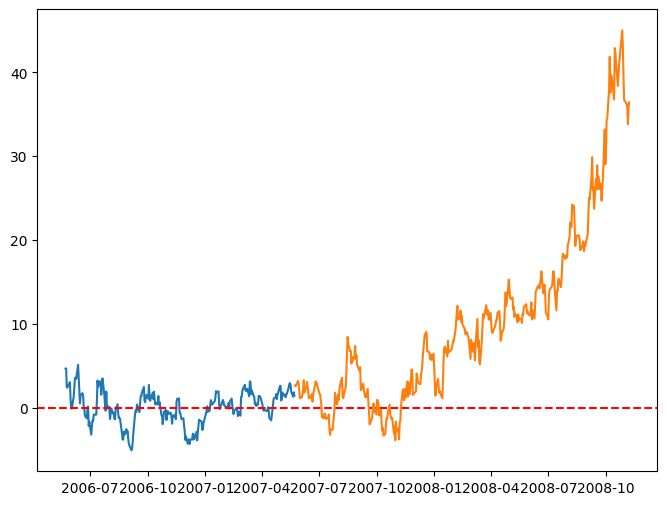

In [61]:
model = sm.OLS(df.loc[:, 'Adj Close_GLD'].iloc[train], df.loc[:, 'Adj Close_GDX'].iloc[train])
result = model.fit()
b = result.params[0]

spread = df.loc[:,'Adj Close_GLD'] - b * df.loc[:,'Adj Close_GDX']
plt.plot(spread.iloc[train])
plt.axhline(0, linestyle='--', color='r')
plt.plot(spread.iloc[test])


In [62]:
from statsmodels.tsa.stattools import adfuller
adfuller(spread)

(0.7472296610173964,
 0.9907347907131245,
 7,
 614,
 {'1%': -3.4410451945636207,
  '5%': -2.8662587328558566,
  '10%': -2.569282988466721},
 1929.3087991915909)

In [63]:
from statsmodels.tsa.stattools import coint
if coint(df1,df2)[1] < 0.05:
    print ('pvalue is: ', coint(df1,df2)[1],  'the series are cointegrated')
else:
    print ('pvalue is: ', coint(df1,df2)[1],  'the series are not cointegrated')


pvalue is:  0.9923371255870279 the series are not cointegrated


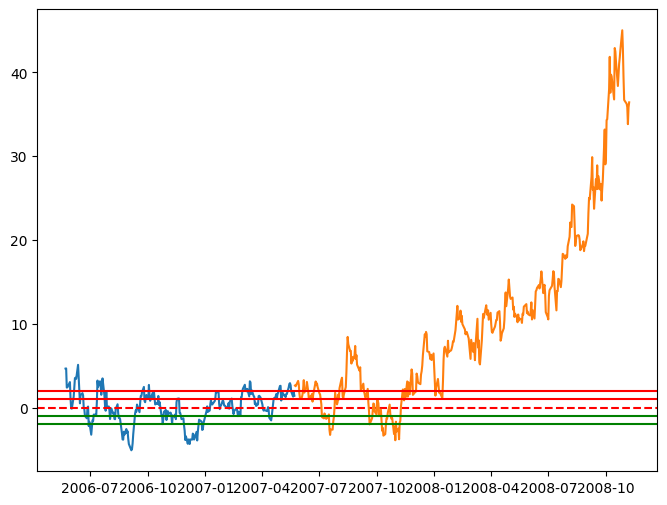

In [64]:
spreadMean = np.mean(spread.iloc[train])
spreadStd = np.std(spread.iloc[train])
df['zscore'] = (spread - spreadMean) / spreadStd
df['position_GLD_long'] = 0
df['position_GDX_long'] = 0
df['position_GDX_short'] = 0
df['position_GLD_short'] = 0

#short spread
df.loc[df.zscore >=2, ('position_GLD_short', 'position_GDX_short' ) ] = [-1 , 1]

#buy spread
df.loc[df.zscore <=-2, ('position_GLD_long', 'position_GDX_long' ) ] = [1 , -1]

#exit short spread
df.loc[df.zscore <=1, ('position_GLD_short', 'position_GDX_short' ) ] = 0

#exit long spread
df.loc[df.zscore >=-1, ('position_GLD_long', 'position_GDX_long' ) ] = 0
df.fillna(method='ffill', inplace=True)

plt.plot(spread.iloc[train])
plt.axhline(0, linestyle='--', color='r')
plt.plot(spread.iloc[test])
plt.axhline(2, color='r')
plt.axhline(1, color='r')
plt.axhline(-1, color='g')
plt.axhline(-2, color='g')

position_long = df.loc[:, ('position_GLD_long', 'position_GDX_long')]
position_short = df.loc[:, ('position_GLD_short', 'position_GDX_short')]

position = np.array(position_long) + np.array(position_short)
position=pd.DataFrame(position)



In [65]:
dailyret = df.loc[:, ( 'Adj Close_GLD', 'Adj Close_GDX')].pct_change()

pnl=(np.array(position.shift())*np.array(dailyret)).sum(axis=1)


In [66]:
sharpetrain = np.sqrt(624) * np.mean(pnl[train[1:]]) / np.std(pnl[train[1:]])
sharpetrain

3.3383164142725477

In [67]:
sharpetest = np.sqrt(624) * np.mean(pnl[test]) / np.std(pnl[test])
sharpetest

-0.9886827972313492

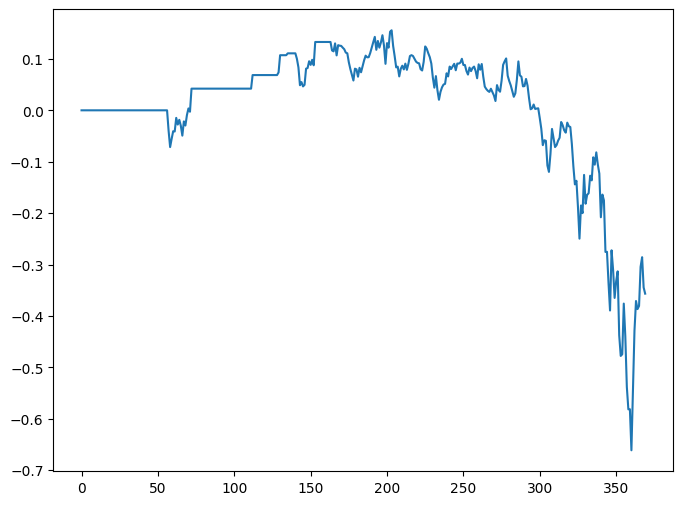

In [68]:
plt.plot(np.cumsum(pnl[test]))
